In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import accuracy_score, roc_auc_score, r2_score
from sklearn.model_selection import train_test_split
import RandomForest
import LinearRegression
import torch

In [2]:
df = pd.read_csv('time_series.csv')
df['stay_key'] = df['stay_id']
cols = ['Time', 'stay_id', 'stay_key', 'hadm_id', 'age', 'gender', 'Heart Rate',
       'Respiratory Rate', 'SpO2/SaO2', 'pH', 'Potassium', 'Calcium',
       'Glucose', 'Sodium', 'HCO3', 'White Blood Cells', 'Hemoglobin',
       'Red Blood Cells', 'Platelet Count', 'Weight', 'Urea Nitrogen',
       'Creatinine', 'Blood Pressure', '1 hours urine output',
       '6 hours urine output', 'AKI', 'gcs',
       'ventilation', 'vasoactive medications', 'sedative medications']
filled = df.groupby('stay_id')[cols].ffill().bfill()
filled['AKI_hour'] = filled.apply(lambda x: x['Time'] if x['AKI'] == 1 else 0, axis=1)
AKI_time = filled[filled['AKI'] == 1].groupby('stay_key')['AKI_hour'].first()
new = pd.merge(filled, AKI_time, left_on=['stay_key'], right_index=True, how='left').drop('AKI_hour_x', axis=1).rename({'AKI_hour_y': 'AKI_time'}, axis=1)
new['time_to_AKI'] = (pd.to_datetime(new['AKI_time']) - pd.to_datetime(new['Time'])) / np.timedelta64(1, 'h')
#new = new[~(new['time_to_AKI'] < 0)]
new['AKI_happen'] = new['time_to_AKI'].apply(lambda x: 0 if pd.isna(x) else 1)

In [3]:
features = ['age', 'gender', 'Heart Rate',
       'Respiratory Rate', 'SpO2/SaO2', 'pH', 'Potassium', 'Calcium',
       'Glucose', 'Sodium', 'HCO3', 'White Blood Cells', 'Hemoglobin',
       'Red Blood Cells', 'Platelet Count', 'Weight', 'Urea Nitrogen',
       'Creatinine', 'Blood Pressure', '1 hours urine output',
       '6 hours urine output', 'gcs',
       'ventilation', 'vasoactive medications', 'sedative medications','AKI']
features_ids = ['stay_key','age', 'gender', 'Heart Rate',
       'Respiratory Rate', 'SpO2/SaO2', 'pH', 'Potassium', 'Calcium',
       'Glucose', 'Sodium', 'HCO3', 'White Blood Cells', 'Hemoglobin',
       'Red Blood Cells', 'Platelet Count', 'Weight', 'Urea Nitrogen',
       'Creatinine', 'Blood Pressure', '1 hours urine output',
       '6 hours urine output', 'gcs', 
       'ventilation', 'vasoactive medications', 'sedative medications','AKI']
features_labels = ['stay_key', 'age', 'gender', 'Heart Rate',
       'Respiratory Rate', 'SpO2/SaO2', 'pH', 'Potassium', 'Calcium',
       'Glucose', 'Sodium', 'HCO3', 'White Blood Cells', 'Hemoglobin',
       'Red Blood Cells', 'Platelet Count', 'Weight', 'Urea Nitrogen',
       'Creatinine', 'Blood Pressure', '1 hours urine output',
       '6 hours urine output', 'gcs',
       'ventilation', 'vasoactive medications', 'sedative medications', 'label_creatinine', 'label_urine', 'label_AKI']
features_train = ['stay_key','age', 'gender', 'Heart Rate',
       'Respiratory Rate', 'SpO2/SaO2', 'pH', 'Potassium', 'Calcium',
       'Glucose', 'Sodium', 'HCO3', 'White Blood Cells', 'Hemoglobin',
       'Red Blood Cells', 'Platelet Count', 'Weight', 'Urea Nitrogen',
       'Creatinine', 'Blood Pressure', '1 hours urine output',
       '6 hours urine output', 'gcs', 'AKI',
       'ventilation', 'vasoactive medications', 'sedative medications', 'real_creatinine', 'real_urine_1', 'real_urine_6']
labels = ['label_creatinine', 'label_urine', 'label_AKI', 'label_AKI_happen']

In [4]:
# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy
 
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
 
# seaborn plotting style
sns.set(style='ticks', context='poster')

In [75]:
# data processing, test train split
X_rolling_train = pd.DataFrame(0,columns=features,index=range(0)) 
X_rolling_test = pd.DataFrame(0,columns=features,index=range(0)) 
y_rolling_train = pd.DataFrame(0,columns=labels,index=range(0)) 
y_rolling_test = pd.DataFrame(0,columns=labels,index=range(0)) 
#train = pd.DataFrame(0,columns=features.append(labels),index=range(0)) 
#test = pd.DataFrame(0,columns=features.append(labels),index=range(0)) 
#ewm = pd.DataFrame(0,columns=features_labels,index=range(0)) 
stay_id = new.groupby('stay_key').first().index

for i in range(200):#(AKI_time.index.shape[0]):
    patient = new[new['stay_key'] == stay_id[i]]
    #patient['time_from_baseline'] = (pd.to_datetime(patient['Time']) - pd.to_datetime(patient['Time'].values[0])) / np.timedelta64(1, 'h')
    patient_rolling = patient[features_ids].rolling(window=3,center = False).mean()#.ewm(com=0.5).mean()#
    patient_rolling['AKI'] = patient['AKI']
    patient_rolling['real_creatinine'] = patient['Creatinine']
    patient_rolling['real_urine_1'] = patient['1 hours urine output']
    patient_rolling['real_urine_6'] = patient['6 hours urine output']
    patient_rolling['label_creatinine'] = patient['Creatinine'].shift(1)
    patient_rolling['label_urine'] = patient['6 hours urine output'].shift(1)
    patient_rolling['label_AKI'] = patient['AKI'].shift(1)
    patient_rolling['label_AKI_happen'] = patient['AKI_happen']

    
    rand = np.random.rand(1)
    if rand>0.8:
        X_rolling_train = pd.concat([X_rolling_train, patient_rolling.dropna()[features_train]], axis = 0)
        y_rolling_train = pd.concat([y_rolling_train, patient_rolling.dropna()[labels]], axis = 0)
    else:
        X_rolling_test = pd.concat([X_rolling_test, patient_rolling.dropna()[features_train]], axis = 0)
        y_rolling_test = pd.concat([y_rolling_test, patient_rolling.dropna()[labels]], axis = 0)


In [63]:
# nonlinear model to predict AKI_happen
from sklearn.base import clone
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

models = []
models.append(KNeighborsRegressor(n_neighbors=7))
models.append(DecisionTreeRegressor())
models.append(ExtraTreeRegressor())
models.append(SVR())
# # ensemble models
n_trees = 20
models.append(AdaBoostRegressor(n_estimators=n_trees))
models.append(BaggingRegressor(n_estimators=n_trees))
models.append(RandomForestRegressor(n_estimators=n_trees))
models.append(ExtraTreesRegressor(n_estimators=n_trees))
models.append(GradientBoostingRegressor(n_estimators=n_trees))
print('Defined %d models' % len(models))

for i in range(9):
    model = clone(models[i])
    model.fit(X_rolling_train[features], y_rolling_train['label_AKI_happen'])
    #print(model.score(X_rolling_train[features], y_rolling_train['label_AKI']))
    y_hat = model.predict(X_rolling_test[features])
    for i in range(y_hat.shape[0]):
        if y_hat[i]<0.5:
            y_hat[i] = int(0)
        else:
            y_hat[i] = int(1)
    print(roc_auc_score(y_rolling_test['label_AKI_happen'].astype(int), y_hat.astype(int)))

Defined 9 models
0.5055303173053314
0.5192065653710651
0.5065357646561717
0.513507498196588
0.5737146478921493
0.48598905961822864
0.5098865611075899
0.4825360444467284
0.5275275174964265


In [64]:
# nonlinear model to predict AKI in next hour
for i in range(9):
    model = clone(models[i])
    model.fit(X_rolling_train[features], y_rolling_train['label_AKI'])
    #print(model.score(X_rolling_train[features], y_rolling_train['label_AKI']))
    y_hat = model.predict(X_rolling_test[features])
    for i in range(y_hat.shape[0]):
        if y_hat[i]<0.5:
            y_hat[i] = int(0)
        else:
            y_hat[i] = int(1)
    print(roc_auc_score(y_rolling_test['label_AKI'].astype(int), y_hat.astype(int)))

0.6179988816663171
0.5636814146921088
0.5572459635143636
0.5
0.6778571328720207
0.5489859509331098
0.5385488222548402
0.5420496260571749
0.6286048787306913


In [76]:
# linear model to predict creatinine and urine
from sklearn.base import clone
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import SGDRegressor

models = []
models.append(LinearRegression())
models.append(Lasso())
models.append(Ridge())
models.append(ElasticNet())
models.append(HuberRegressor())
models.append(LassoLars())
models.append(PassiveAggressiveRegressor(max_iter=1000, tol=1e-3))
models.append(SGDRegressor(max_iter=1000, tol=1e-3))
print('Defined %d models' % len(models))

for i in range(8):
    model_c_r = clone(models[i])
    model_c_r.fit(X_rolling_train[features], y_rolling_train['label_creatinine'])
    c_train = r2_score(model_c_r.predict(X_rolling_train[features]), y_rolling_train['label_creatinine'])
    c_test = r2_score(model_c_r.predict(X_rolling_test[features]), y_rolling_test['label_creatinine'])


    model_u_r = clone(models[i])
    model_u_r.fit(X_rolling_train[features], y_rolling_train['label_urine'])
    u_train = r2_score(model_u_r.predict(X_rolling_train[features]), y_rolling_train['label_urine'])
    u_test = r2_score(model_u_r.predict(X_rolling_test[features]), y_rolling_test['label_urine'])
    
    print(i, c_train, c_test, u_train, u_test)
#print(model_u_r.score(X_rolling_test[features], y_rolling_test['label_urine']))
#print(accuracy_score(y_rolling_test['label_creatinine'], model_u_r.predict(X_rolling_test[features])))

Defined 8 models
0 0.998940174786635 0.9991676809236982 0.9724664390347805 0.9704082324700213
1 0.40638775534517835 0.21926817450477443 0.9724196753992961 0.9703387680275487
2 0.9989399657990629 0.9991675998532313 0.972466422761644 0.9704086083353587
3 0.7276217307951451 0.6230479714201953 0.9724258963589316 0.9703471467124412


/Users/mx_mac/opt/anaconda3/envs/ME5406/lib/python3.6/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/mx_mac/opt/anaconda3/envs/ME5406/lib/python3.6/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


4 0.7686557010679771 0.5630273453346226 0.9717524001203588 0.9695918931147104
5 0.0 0.0 0.9161138150614632 0.9119845141688062
6 0.9961992440069319 0.9952981947813379 0.9515583719509191 0.9479438880922961
7 -0.7456173430352264 -0.7798612558290994 -2.0004105997054884 -2.198588013368936


In [74]:
# try different window size for creatinine and urine prediction
U = [[] for i in range(8)]
C = [[] for i in range(8)]
W = []
for w in range(49):
    X_rolling_train = pd.DataFrame(0,columns=features,index=range(0)) 
    X_rolling_test = pd.DataFrame(0,columns=features,index=range(0)) 
    y_rolling_train = pd.DataFrame(0,columns=labels,index=range(0)) 
    y_rolling_test = pd.DataFrame(0,columns=labels,index=range(0)) 
    stay_id = new.groupby('stay_key').first().index

    for i in range(200):#(AKI_time.index.shape[0]):
        patient = new[new['stay_key'] == stay_id[i]]
        #patient['time_from_baseline'] = (pd.to_datetime(patient['Time']) - pd.to_datetime(patient['Time'].values[0])) / np.timedelta64(1, 'h')
        patient_rolling = patient[features_ids].rolling(window=w+1,center = False).mean()
        patient_rolling['AKI'] = patient['AKI']
        patient_rolling['real_creatinine'] = patient['Creatinine']
        patient_rolling['real_urine_1'] = patient['1 hours urine output']
        patient_rolling['real_urine_6'] = patient['6 hours urine output']
        patient_rolling['label_creatinine'] = patient['Creatinine'].shift(1)
        patient_rolling['label_urine'] = patient['6 hours urine output'].shift(1)
        patient_rolling['label_AKI'] = patient['AKI'].shift(1)
        patient_rolling['label_AKI_happen'] = patient['AKI_happen']


        rand = np.random.rand(1)
        if rand>0.8:
            X_rolling_train = pd.concat([X_rolling_train, patient_rolling.dropna()[features_train]], axis = 0)
            y_rolling_train = pd.concat([y_rolling_train, patient_rolling.dropna()[labels]], axis = 0)
        else:
            X_rolling_test = pd.concat([X_rolling_test, patient_rolling.dropna()[features_train]], axis = 0)
            y_rolling_test = pd.concat([y_rolling_test, patient_rolling.dropna()[labels]], axis = 0)
        
    for i in range(8):
        model_c_r = clone(models[i])
        model_c_r.fit(X_rolling_train[features], y_rolling_train['label_creatinine'])
        c_train = r2_score(model_c_r.predict(X_rolling_train[features]), y_rolling_train['label_creatinine'])
        c_test = r2_score(model_c_r.predict(X_rolling_test[features]), y_rolling_test['label_creatinine'])


        model_u_r = clone(models[i])
        model_u_r.fit(X_rolling_train[features], y_rolling_train['label_urine'])
        u_train = r2_score(model_u_r.predict(X_rolling_train[features]), y_rolling_train['label_urine'])
        u_test = r2_score(model_u_r.predict(X_rolling_test[features]), y_rolling_test['label_urine'])
        U[i].append(u_test)
        C[i].append(c_test)
            
    W.append(w)

/Users/mx_mac/opt/anaconda3/envs/ME5406/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


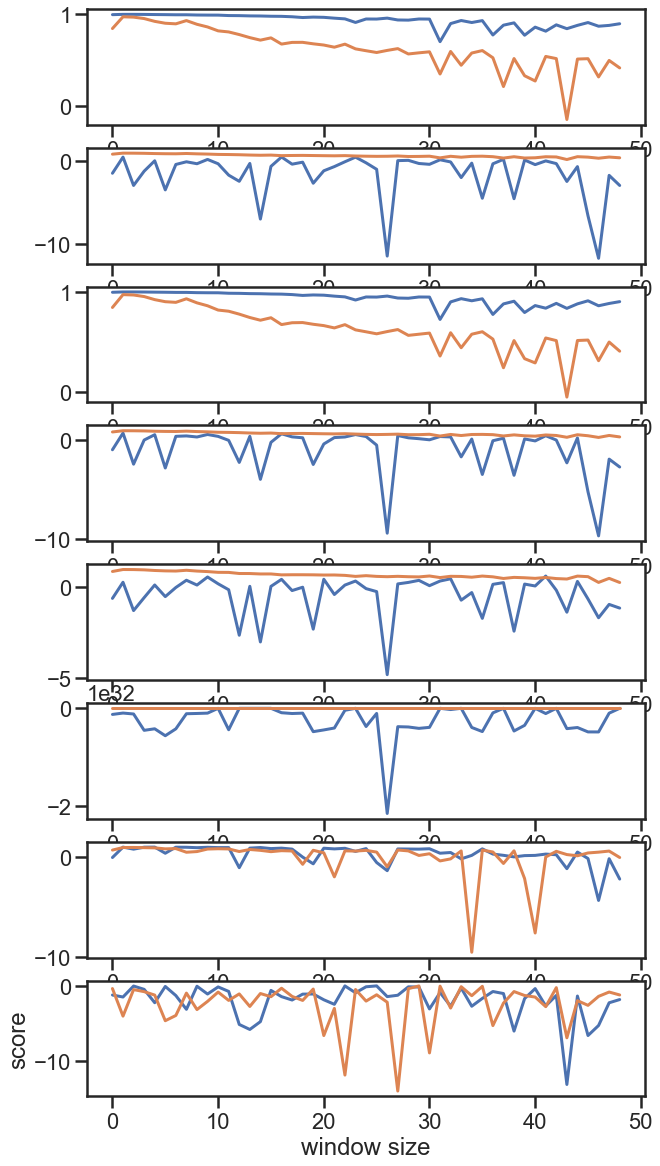

In [53]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,20))
for i in range(8):
    plt.subplot(8,1,i+1)
    plt.plot(W, C[i])
    #plt.ylim([0,1])
for i in range(8):
    plt.subplot(8,1,i+1)
    plt.plot(W, U[i])
    #plt.ylim([0,1])
plt.xlabel('window size')
plt.ylabel('score')
plt.savefig('./linear.jpg')

In [82]:
#try different window size for AKI prediction
Score = []
W = []
for w in range(20):
    X_rolling_train = pd.DataFrame(0,columns=features,index=range(0)) 
    X_rolling_test = pd.DataFrame(0,columns=features,index=range(0)) 
    y_rolling_train = pd.DataFrame(0,columns=labels,index=range(0)) 
    y_rolling_test = pd.DataFrame(0,columns=labels,index=range(0)) 

    for i in range(200):#(AKI_time.index.shape[0]):
        patient = new[new['stay_key'] == stay_id[i]]
        #patient['time_from_baseline'] = (pd.to_datetime(patient['Time']) - pd.to_datetime(patient['Time'].values[0])) / np.timedelta64(1, 'h')
        patient_rolling = patient[features_ids].rolling(window=3,center = False).mean()#.ewm(com=0.5).mean()#
        patient_rolling['AKI'] = patient['AKI']
        patient_rolling['real_creatinine'] = patient['Creatinine']
        patient_rolling['real_urine_1'] = patient['1 hours urine output']
        patient_rolling['real_urine_6'] = patient['6 hours urine output']
        patient_rolling['label_creatinine'] = patient['Creatinine'].shift(1)
        patient_rolling['label_urine'] = patient['6 hours urine output'].shift(1)
        patient_rolling['label_AKI'] = patient['AKI'].shift(1)
        patient_rolling['label_AKI_happen'] = patient['AKI_happen']

        rand = np.random.rand(1)
        if rand>0.8:
            X_rolling_train = pd.concat([X_rolling_train, patient_rolling.dropna()[features_train]], axis = 0)
            y_rolling_train = pd.concat([y_rolling_train, patient_rolling.dropna()[labels]], axis = 0)
        else:
            X_rolling_test = pd.concat([X_rolling_test, patient_rolling.dropna()[features_train]], axis = 0)
            y_rolling_test = pd.concat([y_rolling_test, patient_rolling.dropna()[labels]], axis = 0)

    model_c_r = clone(models[1])
    model_c_r.fit(X_rolling_train[features], y_rolling_train['label_creatinine'])

    model_u_r = clone(models[1])
    model_u_r.fit(X_rolling_train[features], y_rolling_train['label_urine'])
    
    esti = X_rolling_test.merge(y_rolling_test, how='outer', left_on=X_rolling_test.index, right_on=y_rolling_test.index)
    esti['AKI_pre'] = esti['AKI']
    esti['creatinine_pre'] = model_c_r.predict(X_rolling_test[features])
    esti['urine_pre'] = model_u_r.predict(X_rolling_test[features])

    final = pd.DataFrame(0,columns=esti.columns,index=range(0)) 

    for i in range(500):
        patient = esti[esti['stay_key'] == stay_id[i]]
        if patient.values.shape[0]==0:
            continue
        crestinine_baseline = patient['real_creatinine'].values[0]
        #patient['time_from_baseline'] = (pd.to_datetime(patient['Time']) - pd.to_datetime(patient['Time'].values[0])) / np.timedelta64(1, 'h')
        for j in range(patient.index.shape[0]):
            dura = 48
            if j<48:
                patient.drop(patient.index[j])
                continue
            patient_crestinine_1 = (patient['creatinine_pre'].values[j]-patient['real_creatinine'].values[j-dura:j-1])>=0.3
            patient_crestinine_1 = sum(patient_crestinine_1.astype(int))>0

            if j>=7*24:
                crestinine_baseline = patient['real_creatinine'].values[j-7*24]
            patient_crestinine_2 = patient['creatinine_pre'].values[j]/crestinine_baseline>=1.5

            patient_urine = 0
            if j>=5:
                patient_urine_1 = (patient['urine_pre'].values[j-5:j]-0.5)>0
                patient_urine_1 = ~(sum(patient_urine_1.astype(int))>0)
                #patient_urine_2 = (patient['real_urine_6'].values[j-5:j]-0.5)>0
               # patient_urine_2 = ~(sum(patient_urine_2.astype(int))>0)
               # patient_urine = patient_urine and patient['real_urine'].values[j]<0.5
                if patient_crestinine_1+patient_crestinine_2+patient_urine_1 > 0:
                    patient['AKI_pre'].values[j] = 1
                else:
                    patient['AKI_pre'].values[j] = 0
            else: 
                patient.drop(patient.index[j])
                continue
        final = pd.concat([final, patient.dropna()], axis = 0)

    Score.append(roc_auc_score(np.array(final['AKI'].values.astype(int)), np.array(final['AKI_pre'].astype(int))))
    W.append(w)

    

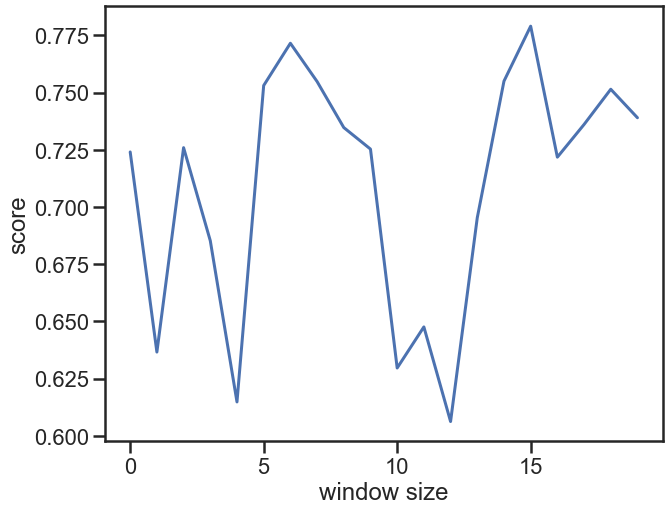

In [83]:
fig = plt.figure(figsize=(10,8))
plt.plot(W, Score)
plt.xlabel('window size')
plt.ylabel('score')
plt.savefig('./AKI.jpg')

In [78]:
# estimate AKI using predicted creatinine and urine
esti = X_rolling_test.merge(y_rolling_test, how='outer', left_on=X_rolling_test.index, right_on=y_rolling_test.index)
esti['AKI_pre'] = esti['AKI']
esti['creatinine_pre'] = model_c_r.predict(X_rolling_test[features])
esti['urine_pre'] = model_u_r.predict(X_rolling_test[features])

final = pd.DataFrame(0,columns=esti.columns,index=range(0)) 

for i in range(500):
    patient = esti[esti['stay_key'] == stay_id[i]]
    if patient.values.shape[0]==0:
        continue
    crestinine_baseline = patient['real_creatinine'].values[0]
    #patient['time_from_baseline'] = (pd.to_datetime(patient['Time']) - pd.to_datetime(patient['Time'].values[0])) / np.timedelta64(1, 'h')
    for j in range(patient.index.shape[0]):
        dura = 48
        if j<48:
            patient.drop(patient.index[j])
            continue
        patient_crestinine_1 = (patient['creatinine_pre'].values[j]-patient['real_creatinine'].values[j-dura:j-1])>=0.3
        patient_crestinine_1 = sum(patient_crestinine_1.astype(int))>0
        
        if j>=7*24:
            crestinine_baseline = patient['real_creatinine'].values[j-7*24]
        patient_crestinine_2 = patient['creatinine_pre'].values[j]/crestinine_baseline>=1.5

        patient_urine = 0
        if j>=5:
            patient_urine_1 = (patient['urine_pre'].values[j-5:j]-0.5)>0
            patient_urine_1 = ~(sum(patient_urine_1.astype(int))>0)
            #patient_urine_2 = (patient['real_urine_6'].values[j-5:j]-0.5)>0
           # patient_urine_2 = ~(sum(patient_urine_2.astype(int))>0)
           # patient_urine = patient_urine and patient['real_urine'].values[j]<0.5
            if patient_crestinine_1+patient_crestinine_2+patient_urine_1 > 0:
                patient['AKI_pre'].values[j] = 1
            else:
                patient['AKI_pre'].values[j] = 0
        else: 
            patient.drop(patient.index[j])
            continue
    final = pd.concat([final, patient.dropna()], axis = 0)
            
print(roc_auc_score(np.array(final['AKI'].values.astype(int)), np.array(final['AKI_pre'].astype(int))))

0.7206998410180704


In [70]:
#verification of the 'creatinine and urine to AKI' method
veri = new
veri['AKI_def'] = veri['AKI']
final = pd.DataFrame(0,columns=new.columns,index=range(0)) 
final['AKI_def'] = final['AKI']


for i in range(100):
    patient = new[new['stay_key'] == stay_id[i]]#veri[veri['stay_key'] == 30000010]
    if patient.values.shape[0]==0:
        continue
    crestinine_baseline = patient['Creatinine'].values[0]
    #patient['time_from_baseline'] = (pd.to_datetime(patient['Time']) - pd.to_datetime(patient['Time'].values[0])) / np.timedelta64(1, 'h')
    for j in range(patient.index.shape[0]):
        dura = 48
        if j<48:
            patient.drop(patient.index[j])
            continue
        patient_crestinine_1 = (patient['Creatinine'].values[j]-patient['Creatinine'].values[j-dura:j])>=0.3
        patient_crestinine_1 = sum(patient_crestinine_1.astype(int))>0
        #patient_crestinine_1 = (patient['Creatinine'].values[j]-patient['Creatinine'].values[j-dura])>=0.3
        
        if j>=7*24:
            crestinine_baseline = patient['Creatinine'].values[j-7*24]
        patient_crestinine_2 = patient['Creatinine'].values[j]/crestinine_baseline>=1.5

        patient_urine = 0
        if j>=5:
            patient_urine_1 = (patient['1 hours urine output'].values[j-5:j]-0.5)>0
            patient_urine_1 = ~(sum(patient_urine_1.astype(int))>0)
            patient_urine_2 = (patient['6 hours urine output'].values[j-5:j]-0.5)>0
            patient_urine_2 = ~(sum(patient_urine_2.astype(int))>0)
           # patient_urine = patient_urine and patient['real_urine'].values[j]<0.5
            if patient_crestinine_1+patient_crestinine_2+patient_urine_1+patient_urine_2 > 0:
                patient['AKI_def'].values[j] = 1
            else:
                patient['AKI_def'].values[j] = 0
        else: 
            patient.drop(patient.index[j])
            continue
 #   final = patient
    final = pd.concat([final, patient.dropna()], axis = 0)
print(roc_auc_score(np.array(final['AKI'].values.astype(int)), np.array(final['AKI_def'].astype(int))))

0.6632813349565418


In [11]:
#the estimation is not good, take one wrong estimation as an example
final[final['stay_key'] == 30000010]

,Time,stay_key,hadm_id,age,gender,Heart Rate,Respiratory Rate,SpO2/SaO2,pH,Potassium,Calcium,Glucose,Sodium,HCO3,White Blood Cells,Hemoglobin,Red Blood Cells,Platelet Count,Weight,Urea Nitrogen,Creatinine,Blood Pressure,1 hours urine output,6 hours urine output,AKI,gcs,ventilation,vasoactive medications,sedative medications,AKI_time,time_to_AKI,AKI_happen,AKI_def
929728,2166-12-20 10:00:00,30000010,26004550,71,1,76.60000,19.00000,97.00000,7.30000,5.40000,8.70000,147.00000,135.00000,19.00000,13.30000,8.10000,3.00000,173.00000,88.00000,61.00000,4.60000,66.50000,0.00000,0.00000,1,3.00000,0,0,0,2166-12-20 10:00:00,0.00000,1,1
929729,2166-12-20 11:00:00,30000010,26004550,71,1,76.60000,19.00000,97.00000,7.36000,5.10000,8.70000,161.00000,136.00000,19.00000,13.30000,8.10000,3.00000,173.00000,88.00000,61.00000,4.60000,66.50000,0.00000,0.00000,0,3.00000,0,0,0,2166-12-20 10:00:00,-1.00000,1,0
929730,2166-12-20 12:00:00,30000010,26004550,71,1,76.60000,19.00000,97.00000,7.29000,4.50000,8.70000,151.00000,136.00000,19.00000,13.30000,8.75000,3.00000,173.00000,88.00000,61.00000,4.60000,66.50000,0.00000,0.00000,0,3.00000,0,0,0,2166-12-20 10:00:00,-2.00000,1,0
929731,2166-12-20 13:00:00,30000010,26004550,71,1,76.60000,19.40000,98.20000,7.34000,4.30000,8.70000,123.00000,139.00000,19.00000,15.90000,9.10000,3.20000,209.00000,88.00000,61.00000,4.60000,66.50000,15.00000,0.00000,0,3.00000,1,1,1,2166-12-20 10:00:00,-3.00000,1,0
929732,2166-12-20 14:00:00,30000010,26004550,71,1,80.00000,18.00000,100.00000,7.34000,4.30000,8.70000,107.00000,139.00000,19.00000,15.90000,9.10000,3.20000,209.00000,88.00000,61.00000,4.60000,84.50000,50.00000,0.00000,0,3.00000,1,1,1,2166-12-20 10:00:00,-4.00000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930039,2167-01-02 09:00:00,30000010,26004550,71,1,72.00000,24.00000,93.00000,7.45000,3.60000,9.40000,169.00000,131.00000,24.00000,15.70000,9.10000,3.18000,272.00000,90.00000,81.00000,6.60000,75.50000,0.00000,0.00000,0,15.00000,0,0,1,2166-12-20 10:00:00,-311.00000,1,1
930040,2167-01-02 10:00:00,30000010,26004550,71,1,68.00000,15.00000,94.00000,7.45000,3.60000,9.40000,169.00000,131.00000,24.00000,15.70000,9.10000,3.18000,272.00000,90.00000,81.00000,6.60000,68.00000,0.00000,0.00000,0,15.00000,0,0,1,2166-12-20 10:00:00,-312.00000,1,1
930041,2167-01-02 11:00:00,30000010,26004550,71,1,72.00000,22.00000,93.00000,7.45000,3.60000,9.40000,169.00000,131.00000,24.00000,15.70000,9.10000,3.18000,272.00000,90.00000,81.00000,6.60000,71.00000,0.00000,0.00000,0,15.00000,0,0,1,2166-12-20 10:00:00,-313.00000,1,1
930042,2167-01-02 12:00:00,30000010,26004550,71,1,72.00000,20.00000,94.00000,7.45000,3.60000,9.40000,161.00000,131.00000,24.00000,15.70000,9.10000,3.18000,272.00000,90.00000,81.00000,6.60000,71.50000,0.00000,0.00000,0,15.00000,0,0,1,2166-12-20 10:00:00,-314.00000,1,1


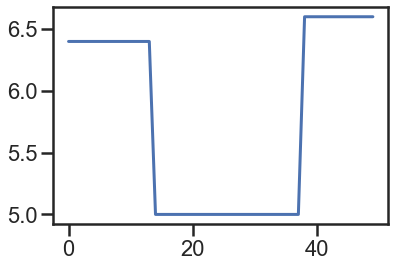

In [12]:
#plot the creatinie in 50 hours 
fig = plt.figure()
plt.plot(final[final['stay_key'] == 30000010][266:316]['Creatinine'].values)

In [13]:
#try some other guess
veri = new
veri['AKI_def'] = veri['AKI']
final = pd.DataFrame(0,columns=new.columns,index=range(0)) 
final['AKI_def'] = final['AKI']


for i in range(100):
    patient = new[new['stay_key'] == stay_id[i]]#veri[veri['stay_key'] == 30000010]
    if patient.values.shape[0]==0:
        continue
    crestinine_baseline = patient['Creatinine'].values[0]
    #patient['time_from_baseline'] = (pd.to_datetime(patient['Time']) - pd.to_datetime(patient['Time'].values[0])) / np.timedelta64(1, 'h')
    for j in range(patient.index.shape[0]):
        dura = 48
        if j<48:
            patient.drop(patient.index[j])
            continue
        patient_crestinine_1 = (patient['Creatinine'].values[j]-patient['Creatinine'].values[j-dura:j])>=0.3
        patient_crestinine_1 = sum(patient_crestinine_1.astype(int))>0
        #patient_crestinine_1 = (patient['Creatinine'].values[j]-patient['Creatinine'].values[j-dura])>=0.3
        
        #if j>=7*24:
        #    crestinine_baseline = patient['Creatinine'].values[j-7*24]
        patient_crestinine_2 = patient['Creatinine'].values[j]/crestinine_baseline>=1.5

        patient_urine = 0
        if j>=5:
            patient_urine_1 = (patient['1 hours urine output'].values[j-5:j]-0.5)>0
            patient_urine_1 = ~(sum(patient_urine_1.astype(int))>0)
            patient_urine_2 = (patient['6 hours urine output'].values[j-5:j]-0.5)>0
            patient_urine_2 = ~(sum(patient_urine_2.astype(int))>0)
           # patient_urine = patient_urine and patient['real_urine'].values[j]<0.5
            if patient_crestinine_1+patient_crestinine_2+patient_urine_1+patient_urine_2 > 0:
                patient['AKI_def'].values[j] = 1
            else:
                patient['AKI_def'].values[j] = 0
        else: 
            patient.drop(patient.index[j])
            continue
 #   final = patient
    final = pd.concat([final, patient.dropna()], axis = 0)
print(roc_auc_score(np.array(final['AKI'].values.astype(int)), np.array(final['AKI_def'].astype(int))))

0.6489708405940094
